# Swiss报告可视化
## 数据预处理和可视化，节省月度杂志制作时间

报告包括四部分：
- social buzz
- **ec sales**
- ec comments
- kol



In [2]:
import pandas as pd

import numpy as np
'''from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics.pairwise import pairwise_distances_argmin
from wordcloud import WordCloud'''
import matplotlib as mpl
import matplotlib.pyplot as plt

from matplotlib import font_manager

from IPython.display import display, HTML
import matplotlib as mpl 
from matplotlib.font_manager import *    
import seaborn as sns
sns.set_style("whitegrid")

from itertools import cycle, islice

title_fsize = 15
brand_colors  = ['blue', 'darkorange', 'grey', 'yellow']
store_colors = ['red', 'purple', 'green']
%matplotlib inline
mpl.style.use('default')
#指定默认字体  
myfont = FontProperties(fname="C:\Windows\Fonts\msyh.ttc")  

# paths = [os.path.join(rcParams['datapath'], 'fonts', 'ttf'),
#                  os.path.join(rcParams['datapath'], 'fonts', 'afm'),
#                  os.path.join(rcParams['datapath'], 'fonts', 'pdfcorefonts')]
# ttffiles=findSystemFonts(paths)
# createFontList(ttffiles)


## prepare data
##### ec sales

In [7]:
brands = ['tissot','fiyta','casio','longines']
brand_index = ['TISSOT', 'FIYTA', 'CASIO', 'LONGINES']
cols = ['date','brand','store','item','price','sales_30days', 'item_url','image_url','platform','geo','dist_type','store_type']
df_ec_sales = None
dir =r"../data/201804/"
ec_filepath=""
def map_plt_store(x):
        if x.startswith('淘宝'):
            return '淘宝'
        else:
            return x

for root, dirs, files in os.walk(dir):
      for fn in files:
             if fn.startswith("~$") or os.path.splitext(fn)[1] not in [".xlsx",".xlsm"]:
                    continue
             file_name = os.path.splitext(fn)[0]
             file_path = os.path.join(root,fn)
             #print(file_name+'  :   '+file_path)
             if '电商' in file_name.lower():
                         ec_filepath=file_path
   

if not os.path.isfile(ec_filepath):
    print("No EC file found!") 
else:
    for b_ in brands:
        print(b_)
        df_sale = pd.read_excel(ec_filepath,b_, names=cols) # usecols="A:L",
        df_sale= df_sale[df_sale.brand== b_]
    #     print(df_sale.shape)
        df_ec_sales = pd.concat([df_ec_sales,df_sale], axis =0)
    #     print(df_ec_sales.shape)
    
    df_ec_sales = df_ec_sales.dropna()
    df_ec_sales = df_ec_sales.assign(amt = lambda o: o.price * o.sales_30days)
    ## preprocess
    ## fix data error
    df_ec_sales.loc[df_ec_sales.store_type.str.contains('非旗舰'),'store_type'] ='非旗舰店'
    

    
    df_ec_sales.brand = df_ec_sales.brand.str.upper()
    
    df_ec_sales = df_ec_sales.assign(platform_store = lambda o: o.platform + o.store_type)
    df_ec_sales['platform_store'] = df_ec_sales['platform_store'].map(map_plt_store)
    df_ec_sales['brand'] = pd.Categorical( df_ec_sales.brand, categories=brand_index, ordered= True)
    display(df_ec_sales.head() )
    

tissot
fiyta
casio
longines


,date,brand,store,item,price,sales_30days,item_url,image_url,platform,geo,dist_type,store_type,amt,platform_store
1,2018-03-31,TISSOT,天猫国际官方直营,【直营】瑞士Tissot/天梭手表石英钢带女表T058.009.11.031.00,1459.0,84.0,https://detail.tmall.com/item.htm?id=552375289...,https://g-search3.alicdn.com/img/bao/uploaded/...,天猫,海外,直营,天猫国际,122556.0,天猫天猫国际
2,2018-03-31,TISSOT,天猫国际官方直营,【直营】瑞士Tissot/天梭手表库图石英女表T035.210.16.371.00,1499.0,27.0,https://detail.tmall.com/item.htm?id=552410742...,https://g-search2.alicdn.com/img/bao/uploaded/...,天猫,海外,直营,天猫国际,40473.0,天猫天猫国际
3,2018-03-31,TISSOT,拜尔芙海外专营店,手表 天梭力洛克瑞士自动机械男表T006.407.11.053.00/033,2700.0,358.0,https://detail.tmall.com/item.htm?id=413394369...,https://g-search1.alicdn.com/img/bao/uploaded/...,天猫,海外,非直营,天猫国际,966600.0,天猫天猫国际
4,2018-03-31,TISSOT,茗豪海外专营店,香港发货 瑞士天梭手表力洛克男表T006.407.16.033.00皮带机械表,2772.0,211.0,https://detail.tmall.com/item.htm?id=410966744...,https://g-search3.alicdn.com/img/bao/uploaded/...,天猫,海外,非直营,天猫国际,584892.0,天猫天猫国际
5,2018-03-31,TISSOT,拜尔芙海外专营店,全球联保 瑞士手表 天梭魅时系列石英女表T109.210.11.031.00,1220.0,180.0,https://detail.tmall.com/item.htm?id=400532252...,https://g-search3.alicdn.com/img/bao/uploaded/...,天猫,海外,非直营,天猫国际,219600.0,天猫天猫国际


##  各平台销售销售

In [9]:
"""
淘宝
"""
# print(__doc__)

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def plot_sales(platform = None, store_type= None):
    agg_dict = {
            'sales_30days':['sum'],
            'amt': ['sum'],  
            'price': ['mean']}
    index = ['tissot','fiyta','casio','longines','Grand Total']
    df_agg = df_ec_sales
    
    if platform:
        df_agg = df_agg.where(df_agg.platform==platform)
    if store_type:
        df_agg = df_agg.where(df_agg.store_type==store_type)
        
    df_agg = df_agg[['brand','sales_30days', 'amt', 'price']].groupby('brand').agg(agg_dict).reset_index()
    df_agg.columns = ['品牌','月销量','总价','平均件单价']

    df_table = df_agg.pivot_table(index=['品牌'],values =['月销量','总价','平均件单价'],aggfunc=np.sum,margins=True,margins_name='Grand Total')

    df_table = df_table.reindex(index)
    df_table = df_table.reindex_axis(['月销量','总价','平均件单价'], axis=1)
    df_table.loc['Grand Total','平均件单价'] = df_ec_sales['price'].mean()
    
    df_data = df_table.iloc[:-1,]['月销量']
    labels = [ '{:,.0f}'.format(n) for n in df_data]
    
#     fig = plt.figure(figsize=(6,6))
#     ax = df_data.plot(kind='pie', fig=fig, labels = labels,autopct='%1.0f%%', pctdistance=1.1, labeldistance=.8)
#     ax.set_ylabel('')
#     title = platform + (store_type if store_type else '') + '月销量'
#     ax.set_title(title, fontproperties=myfont,fontsize=15)
#     ax.legend(index[:-1],bbox_to_anchor=(1.02, .6), loc=2, borderaxespad=0.)
    return df_table.dropna().round(1)

# interact(plot_sales,platform = ['淘宝','天猫'], store_type= ['旗舰店','非旗舰店']);
plot_sales()
# plot_sales(platform='天猫')
# plot_sales(platform='天猫',store_type='旗舰店')
# plot_sales(platform='天猫',store_type='非旗舰店')

,月销量,总价,平均件单价
品牌,,,
Grand Total,152736.0,102367619.6,3253.6


sales_30days                                       
brand             TISSOT   FIYTA     CASIO LONGINES Grand Total
platform                                                       
天猫                3314.0  6583.0   76243.0    419.0     86559.0
淘宝                2028.0   635.0   38366.0    428.0     41457.0
Grand Total       5342.0  7218.0  114609.0    847.0    128016.0

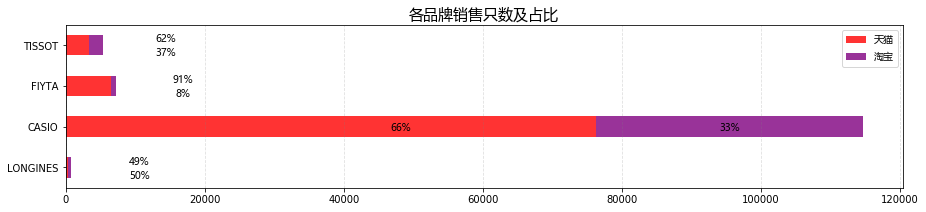

In [15]:
store_index = ['淘宝','天猫旗舰店','天猫非旗舰店']


df_filter = df_ec_sales[df_ec_sales.platform_store.isin(store_index)]

df_agg = df_filter.pivot_table(index=['platform'], columns=['brand'],values =['sales_30days'],aggfunc=np.sum,margins=True,margins_name='Grand Total')
display(df_agg)
df_agg = df_filter.pivot_table(index=['brand'], columns=['platform'],values =['sales_30days'],aggfunc=np.sum)

df_agg.columns = df_agg.columns.levels[1]
df_agg = df_agg.sort_index(ascending=False)
df_agg = df_agg.fillna(0)
f, ax = plt.subplots(1,1,figsize= (15,3))

percentages=df_agg.values/df_agg.sum(axis=1).values.reshape(-1,1)
texts = [""] * df_agg.shape[0]
left = np.zeros(df_agg.shape[0])
for i, br in enumerate(df_agg.columns):
#     rects = ax.barh(df_agg.index, df_agg.loc[brand_index,br], alpha=.8,  left=left,color=store_colors[i])
    
    rects = df_agg.iloc[:,i].reset_index().plot.barh(ax=ax,x='brand', stacked=True, left= left,color=store_colors[i], alpha=.8)
    left += df_agg.iloc[:,i].values
    
# plot data label
for j0,patch in enumerate(ax.patches):
    i = int(j0 /4)
    j = j0 %4
    bl = patch.get_xy()
    x = 0.5*patch.get_width() + (bl[0] + 10000 if bl[0] < 10000 else bl[0])
    y = .8*patch.get_height() + bl[1]
    if df_agg.iloc[j,i]>0:
        txt ="%d%%" % (percentages[j,i]*100)
        texts[j] += "\n"+ txt
    if df_agg.iloc[j,i]>8000 or i== len(df_agg.columns)-1:
        ax.text(x,y, texts[j],ha='center',va='center',
         weight='light', clip_on=True, font_properties= myfont)
        texts[j] =""

        
ax.legend(df_agg.columns,prop= myfont)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('各品牌销售只数及占比', fontproperties=myfont, fontsize=title_fsize);
ax.xaxis.grid(True, linestyle='--', which='major',color='grey', alpha=.25)
# Plot a solid vertical gridline to highlight the median position
ax.axvline(50, color='grey', alpha=0.25)
plt.show()

#### 各平台价位段

In [11]:
df_table2 = df_ec_sales.groupby(['platform','brand']).apply(lambda g: g.amt.sum()/g.sales_30days.sum()).to_frame().unstack()
display(df_table2)

0                                       
brand          CASIO        FIYTA     LONGINES       TISSOT
platform                                                   
天猫        522.958496  1175.933769  7504.296132  1985.027662
淘宝        359.057116  1282.969811  6118.928435  1251.765079

brand,TISSOT,FIYTA,CASIO,LONGINES
platform,,,,
天猫,1985.0,1175.9,523.0,7504.3
淘宝,1251.8,1283.0,359.1,6118.9


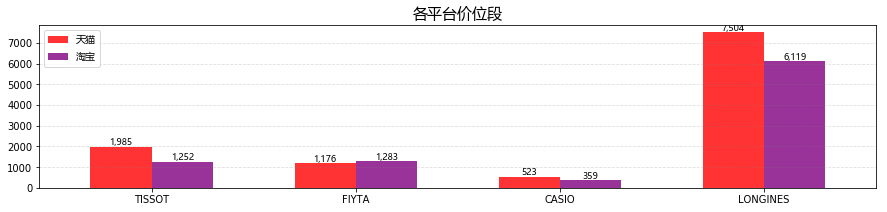

In [20]:
df_table = df_ec_sales.groupby(['platform','brand']).apply(lambda g: g.amt.sum()/g.sales_30days.sum()).to_frame().unstack()

df_table.columns = df_table.columns.levels[1] # reduce to 1 level
df_table = df_table.reindex_axis(brand_index, axis=1)

# labels = ['{:,.0f}'.format(d) for d in df_table['price']]
df_table = df_table.dropna(how='all').round(1)
ax = df_table.transpose().plot(kind='bar', figsize= (15,3), alpha=.8, width=.6, color = store_colors)
ax.legend(df_table.index,prop= myfont)
ax.set_xlabel('')
ax.set_title('各平台价位段', fontproperties=myfont, fontsize=title_fsize);
ax.yaxis.grid( linestyle='--', which='major',color='grey', alpha=.25)
plt.xticks(rotation=360);
# plot data label

for rect in ax.patches:
    height = rect.get_height()

    label = '{:,.0f}'.format(height)
    if height>0:
        ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
                ha='center', va='bottom',weight='light',clip_on=True, font_properties= myfont, fontsize= 9)


df_table
